I built a content categorization system using dataset that contains information about various content pieces, including:

* **Content metadata:** Type of content (image, text), source, and potentially generated content metadata.
* **Engagement data:**  Likes, dislikes, and milliseconds of engagement for each piece of content.

The goal is to develop a system that can accurately classify this content into at least 10 distinct categories.

# Basic Imports

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from tqdm import tqdm

# Reading Data

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/taxonomy_engagement_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
text_data = df[df.media_type == 'Text']
image_data = df[df.media_type == 'Image']

In [ ]:
def display_content(content_id):
    content = df[df['id'] == content_id].iloc[0]

    print(f"**Content ID:** {content_id}")
    display(pd.DataFrame(content).T)  # Use DataFrame for better table formatting
    if content['s3_url']:
        display(Image(url=content['s3_url'], width=300, height=300))

In [ ]:
df.columns

Index(['id', 'user_id', 'content_id', 'engagement_metadata', 'media_type',
       's3_url', 'is_like', 'is_dislike', 'msEngagement', 'seed',
       'num_inference_steps', 'guidance_scale', 'prompt', 'original_prompt',
       'artist_style', 'source', 'generated_type', 'model', 'model_version',
       'text'],
      dtype='object')

In [ ]:
!pip install -q ipywidgets

import pandas as pd
import ipywidgets as widgets
from IPython.display import display, Image, clear_output

# Create widgets for content selection
content_id1_dropdown = widgets.Dropdown(options=df['id'].unique(), description='Content ID 1:')
content_id2_dropdown = widgets.Dropdown(options=df['id'].unique(), description='Content ID 2:')

# Create button for comparison
compare_button = widgets.Button(description="Compare Content")

# Create output area
output = widgets.Output()

# Create a list to store similar pairs
similar_pairs = []

def display_content(content_id):
    """Displays a single content piece."""
    content = df[df['id'] == content_id].iloc[0]

    # Display content information
    print(f"**Content ID:** {content_id}")
    display(pd.DataFrame(content).T)  # Use DataFrame for better table formatting
    if content['s3_url']:
        display(Image(url=content['s3_url'], width=300, height=300))

# Comparison function
def on_compare_button_clicked(b):
    """Handles the comparison logic when the button is clicked."""
    with output:
        clear_output()

        id1 = content_id1_dropdown.value
        id2 = content_id2_dropdown.value

        # Display content side-by-side
        display_content(id1)
        print("-" * 50)
        display_content(id2)

        # Similarity input
        similarity_buttons = widgets.ToggleButtons(
            options=['Similar', 'Not Similar'],
            description='Are these similar?',
            disabled=False,
            button_style='info',
            tooltips=['Yes, they belong to the same category', 'No, they are different']
        )

        def on_similarity_selected(change):
            if change['new'] == 'Similar':
                similar_pairs.append((id1, id2))
                print("Pair added to similar_pairs list!")

        similarity_buttons.observe(on_similarity_selected, names='value')
        display(similarity_buttons)

# Link button click to the comparison function
compare_button.on_click(on_compare_button_clicked)

# Display the interactive UI elements
display(widgets.HBox([content_id1_dropdown, content_id2_dropdown]))
display(compare_button)
display(output)

Button(description='Compare Content', style=ButtonStyle())

Output()

In [ ]:
import pandas as pd
from IPython.display import display, HTML, Image, clear_output
import random

# Load your data
# df = pd.read_csv('content_data.csv')

# De-dupe content data based on 'content_id' (keep first occurrence)
df_dedupe = df.drop_duplicates(subset=['content_id'], keep='first')

# Function to display content side-by-side
def display_content(content1, content2):
    """Displays two content pieces with information and appropriate media."""

    def create_content_html(content):
        """Creates the HTML for a single content piece (image or text)."""
        if content['media_type'] == 'Image' and not pd.isnull(content['s3_url']):
            content_html = f"""
            <img src="{content['s3_url']}" width="300" height="300">
            """
        elif content['media_type'] == 'Text':
            content_html = f"""
            <p><strong>Prompt:</strong> {content['prompt']}</p>
            <p><strong>Text:</strong> {content['text']}</p>
            """
        else:
            content_html = "<p>No Content Available</p>"  # Placeholder
        return content_html

    html_template = """
    <div style="display: flex; justify-content: space-around; margin-bottom: 30px;">
        <div>
            <h3>Content ID: {id1}</h3>
            {content1_html}
            <p>Media Type: {media_type1}</p>
            <!-- Add more metadata as needed -->
        </div>
        <div>
            <h3>Content ID: {id2}</h3>
            {content2_html}
            <p>Media Type: {media_type2}</p>
            <!-- Add more metadata as needed -->
        </div>
    </div>
    """

    content1_html = create_content_html(content1)
    content2_html = create_content_html(content2)

    formatted_html = html_template.format(
        id1=content1['content_id'],
        content1_html=content1_html,
        media_type1=content1['media_type'],
        id2=content2['content_id'],
        content2_html=content2_html,
        media_type2=content2['media_type']
    )
    display(HTML(formatted_html))
    display(pd.DataFrame([content1, content2]))


# Create button for comparison
compare_button = widgets.Button(description="Compare Random Content")

# Create output area
output = widgets.Output()

# Create a list to store similar pairs
similar_pairs = set()
non_similar_pairs = set()

# Comparison logic with random selection
def on_compare_button_clicked(b):
    with output:
        clear_output()

        # Select two random content pieces
        random_content = df_dedupe.sample(2)
        content1, content2 = random_content.iloc[0], random_content.iloc[1]

        global selected_id1, selected_id2
        selected_id1 = content1['content_id']
        selected_id2 = content2['content_id']

        display_content(content1, content2)

        # Create Similarity buttons
        similarity_buttons = widgets.ToggleButtons(
            options=['Similar', 'Not Similar'],
            description='Are these similar?',
            disabled=False,
            button_style='info',
            tooltips=['Yes, they belong to the same category', 'No, they are different'],
            value=None
        )

        # Function to handle similarity button clicks
        def on_similarity_selected(change):
            if change['new'] == 'Similar':
                similar_pairs.add((selected_id1, selected_id2))
                non_similar_pairs.discard((selected_id1, selected_id2))
                print("Pair added to similar_pairs list!")
            else:
                similar_pairs.discard((selected_id1, selected_id2))
                non_similar_pairs.add((selected_id1, selected_id2))
                print("Pair added to non_similar_pairs list!")

        # Observe changes in the similarity_buttons widget
        similarity_buttons.observe(on_similarity_selected, names='value')

        display(similarity_buttons)


# Link button click to comparison function
compare_button.on_click(on_compare_button_clicked)

# Display the interactive UI elements
display(compare_button)
display(output)

Button(description='Compare Random Content', style=ButtonStyle())

Output()

In [ ]:
print("similar_pairs:", similar_pairs)
print("non_similar_pairs:", non_similar_pairs)

similar_pairs: {(90826, 122623)}
non_similar_pairs: set()


In [ ]:
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.downloader as gensim_api
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/taxonomy_engagement_data.csv')

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Data/taxonomy_engagement_data_small.csv')

In [ ]:
image_df = df[df.media_type == 'Image']
text_df = df[df.media_type == 'Text']

# Image Data

## BERT embeddings

In [ ]:
def preprocess_text(text, stopwords, stem, lemma):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    token = text.split()
    token = [word for word in token if word not in stopwords]
    if stem == True:
        ps = nltk.stem.porter.PorterStemmer()
        token = [ps.stem(word) for word in token]
    if lemma == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        token = [lem.lemmatize(word) for word in token]
    text = " ".join(token)
    return text

In [ ]:
stopwords = nltk.corpus.stopwords.words("english")
image_df['prompt_clean'] = image_df['prompt'].apply(lambda x: preprocess_text(x, stopwords, True, True))
text_df['prompt_clean'] = text_df['prompt'].apply(lambda x: preprocess_text(x, stopwords, True, True))

<ipython-input-49-270038224382>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df['prompt_clean'] = image_df['prompt'].apply(lambda x: preprocess_text(x, stopwords, True, True))
<ipython-input-49-270038224382>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['prompt_clean'] = text_df['prompt'].apply(lambda x: preprocess_text(x, stopwords, True, True))


In [ ]:
image_prompts = image_df['prompt_clean'].dropna().tolist()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
    outputs = model(**inputs)
    embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().detach().numpy()
    return embeddings

embeddings = [get_embeddings(prompt) for prompt in image_prompts] # number of documents (images) * dimension 768


In [ ]:
embeddings = [embedding.flatten() for embedding in embeddings]

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/bert_embeddings.npy', np.array(embeddings))

## artist_style

In [ ]:
from sklearn.preprocessing import OneHotEncoder

common_styles = image_df['artist_style'].value_counts()[image_df['artist_style'].value_counts() > 400].index.tolist()
def filter_styles(style):
    if pd.isnull(style):
        return 'other'
    if style in common_styles:
        return style
    else:
        return 'other'
image_df['artist_style'] = image_df['artist_style'].apply(filter_styles)
encoder = OneHotEncoder(sparse=False)
artist_style_encoded = encoder.fit_transform(image_df[['artist_style']])
artist_style_df = pd.DataFrame(artist_style_encoded, columns=encoder.get_feature_names_out(['artist_style']))
artist_style_df.head()

<ipython-input-102-6604f55972e7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df['artist_style'] = image_df['artist_style'].apply(filter_styles)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,artist_style_anime,artist_style_detailed_portrait,artist_style_edward_hopper,artist_style_franck_slama,artist_style_ibrahim_el_salahi,artist_style_jackson_pollock,artist_style_jean-michel_basquiat,artist_style_juan_gris,artist_style_keith_haring,artist_style_ma_jir_bo,artist_style_medieval,artist_style_oil_on_canvas,artist_style_other,artist_style_shepard_fairey,artist_style_studio,artist_style_unreal_engine,artist_style_van_gogh
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## source

In [ ]:
from sklearn.preprocessing import OneHotEncoder

common_sources = image_df.source.value_counts()[image_df.source.value_counts()>300].index.tolist()
def filter_source(source):
    if source in common_sources:
        return source
    else:
        return 'other'
image_df['source'] = image_df['source'].apply(filter_source)
encoder = OneHotEncoder(sparse=False)
source_encoded = encoder.fit_transform(image_df[['source']])
source_df = pd.DataFrame(source_encoded, columns=encoder.get_feature_names_out(['source']))
source_df.head()

<ipython-input-84-a596024075ab>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df['source'] = image_df['source'].apply(filter_source)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,source_human_prompts,source_other,source_r/Damnthatsinteresting,source_r/EarthPorn,source_r/MadeMeSmile,source_r/Showerthoughts,source_r/educationalgifs,source_r/pics,source_r/scifi
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## some other features might be useful

In [ ]:
other_features_df = image_df[['is_like','is_dislike','msEngagement','num_inference_steps','guidance_scale']]
other_features_df.reset_index(drop=True, inplace=True)

## combine features and standardize

In [ ]:
embeddings_df = pd.DataFrame(embeddings)
combined_df = pd.concat([embeddings_df, artist_style_df, source_df, other_features_df], axis=1, ignore_index=True)
combined_df.shape

(49856, 799)

In [ ]:
combined_df = combined_df.fillna(0)

In [ ]:
from sklearn.preprocessing import StandardScaler
combined_df.columns = combined_df.columns.astype(str)
scaler = StandardScaler()
standardized_features = scaler.fit_transform(combined_df)

In [ ]:
from sklearn.decomposition import PCA

n_components=20
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(standardized_features)
pca_df = pd.DataFrame(pca_features, columns=[f'PCA_{i}' for i in range(n_components)])


## KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

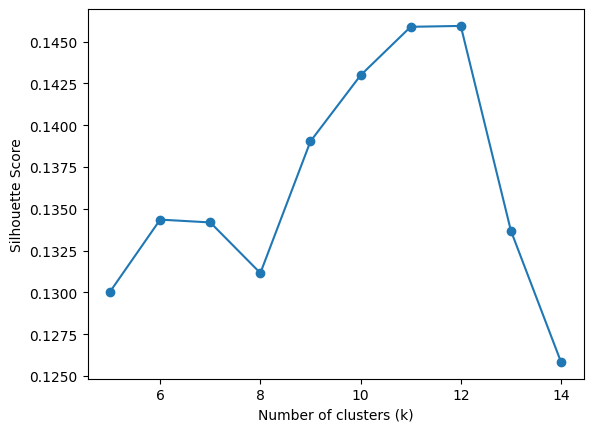

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(5, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pca_df)
    silhouette_avg = silhouette_score(pca_df, labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(5,15), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=12, random_state=42)
kmeans.fit(pca_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=12, random_state=42)

In [ ]:
image_df['cluster'] = kmeans.labels_

<ipython-input-171-47f0f42d59ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df['cluster'] = kmeans.labels_


In [ ]:
image_df['cluster'].value_counts()

,count
cluster,
3,11270
0,6117
5,4667
2,4552
8,4142
11,3759
6,3647
10,3609
7,2840


In [ ]:
from IPython.display import display, Image, clear_output

test = image_df[image_df['cluster'] == 4]
def display_content(content_id):
    """Displays a single content piece."""
    content = df[df['id'] == content_id].iloc[0]

    print(f"**Content ID:** {content_id}")
    display(pd.DataFrame(content).T)
    if content['s3_url']:
        display(Image(url=content['s3_url'], width=300, height=300))
test.apply(lambda x: display_content(x['id']), axis=1)

**Content ID:** 374901


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
11,374901,04a8708c3a481ced13845a30de522486895de0592222c2...,125380,"{""controller"": ""DELTA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,467.0,11.0,50.0,8.0,"God has given you one face, and you make yours...","God has given you one face, and you make yours...",anime,William Shakespeare,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 200208


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
16,200208,bba58959c32abe688d9cb5222b97de973002a67c412d6a...,124814,"{""controller"": ""FOXTROT""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,510.0,11.0,50.0,8.0,A brand for a company is like a reputation for...,A brand for a company is like a reputation for...,anime,Jeff Bezos,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 309041


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
72,309041,04a8708c3a481ced13845a30de522486895de0592222c2...,129342,"{""controller"": ""BETA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,485.0,12.0,20.0,10.0,"Gratitude is not only the greatest of virtues,...","Gratitude is not only the greatest of virtues,...",anime,Cicero,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 262470


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
140,262470,9a72c24f2fd76561729110d804c69f38a7088f2ec41fdf...,122961,"{""controller"": ""DELTA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,334.0,10.0,20.0,4.0,i gave the midjourney ai prompts from my debut...,i gave the midjourney ai prompts from my debut...,anime,r/scifi,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 132537


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
202,132537,f747870ae666c39b589f577856a0f7198b3b81269cb032...,86481,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,2147483647.0,75.0,7.0,"a doughnut scene, everything is doughnuts, per...","a doughnut scene, everything is doughnuts, per...",NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 266692


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
253,266692,9197e4844abed2fea3569a2acf7b0d584c979c333ab7ae...,125426,"{""controller"": ""ALPHA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,1666.0,11.0,50.0,8.0,The best way out is always through..Anime scen...,The best way out is always through.,anime,Robert Frost,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 172819


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
389,172819,8d1ede4f889e0ed6f0823d8c1821905b9de37a0f851dc2...,123413,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,10.0,20.0,4.0,5 extinction events happened that killed from ...,5 extinction events happened that killed from ...,anime,r/Showerthoughts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 94336


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
456,94336,d7cdaa5ca0582076c8e772cce739e32c5077cfd24f2ea3...,110684,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,7.0,50.0,8.0,being in chemo all day is not exactly how i pi...,being in chemo all day is not exactly how i pi...,anime,r/pics,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 265577


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
469,265577,8e6aee9efac8086ebac545d45c63e0d0dfcddd0d77d53e...,113616,"{""controller"": ""ALPHA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,2260.0,9.0,100.0,8.0,my kid said her one birthday wish was to wake ...,my kid said her one birthday wish was to wake ...,anime,r/pics,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 231955


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
474,231955,838f461c2fa673cec73e6eecdafa88b127802d6cb0a61c...,84834,"{""controller"": ""EXAMPLE""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,1038.0,2147483647.0,75.0,7.0,"a climber climbs a snowy mountain in a storm, ...","a climber climbs a snowy mountain in a storm, ...",NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 166550


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
475,166550,e0850a775c17a87060c0cf6efad1020e0cbef5a44ba942...,98270,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,2147483647.0,75.0,7.0,an ancient chinese general holding a long weap...,an ancient chinese general holding a long weap...,NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 397592


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
496,397592,9a72c24f2fd76561729110d804c69f38a7088f2ec41fdf...,123413,"{""controller"": ""ECHO""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,333.0,10.0,20.0,4.0,5 extinction events happened that killed from ...,5 extinction events happened that killed from ...,anime,r/Showerthoughts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 412189


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
511,412189,459535faa370a3b5f8b87203b089623c7aeb9325abf241...,125380,"{""controller"": ""DELTA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,2092.0,11.0,50.0,8.0,"God has given you one face, and you make yours...","God has given you one face, and you make yours...",anime,William Shakespeare,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 298360


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
537,298360,355d8c0ee4e5698eaed38b96aab64dbf0ad72eca3e3521...,127870,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,11.0,50.0,8.0,"Always do your best. What you plant now, you w...","Always do your best. What you plant now, you w...",anime,Og Mandino,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 191671


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
573,191671,983bd614bb5afece5ab3b6023f71147cd7b6bc2314f9d2...,130554,"{""controller"": ""BETA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,665.0,12.0,20.0,10.0,The greatest mistake you can make in life is t...,The greatest mistake you can make in life is t...,anime,Elbert Hubbard,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 385132


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
582,385132,5d8f6cce532a7aeb57196be62344095936793400b3aeb3...,91755,"{""controller"": ""FOXTROT""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,498.0,1401006429.0,75.0,10.0,a big silver dragon and a boy sitting next to ...,a big silver dragon and a boy sitting next to ...,NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 217822


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
615,217822,04a8708c3a481ced13845a30de522486895de0592222c2...,85049,"{""controller"": ""EXAMPLE""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,520.0,1312669608.0,75.0,7.0,"A huge blue kraken in a vast sea, terrifying, ...","A huge blue kraken in a vast sea, terrifying, ...",NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 263574


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
618,263574,9a72c24f2fd76561729110d804c69f38a7088f2ec41fdf...,94608,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,1695361828.0,75.0,9.0,carrier ship sailing on flooded miniature new ...,carrier ship sailing on flooded miniature new ...,NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 320732


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
646,320732,8ede6b26343305e05c3c0029f4e830d4e8c2016869a9d1...,120143,"{""controller"": ""FOXTROT""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,1000.0,10.0,20.0,3.0,i gave the midjourney ai prompts from my debut...,i gave the midjourney ai prompts from my debut...,anime,r/scifi,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 234056


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
648,234056,62a0eae98b9fc0bd0ad941ae07ae5e2af545a64c8ddc43...,125839,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,11.0,50.0,8.0,If you spend too much time thinking about a th...,If you spend too much time thinking about a th...,anime,Bruce Lee,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 431593


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
656,431593,04a8708c3a481ced13845a30de522486895de0592222c2...,90517,"{""controller"": ""BETA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,1316.0,1494940705.0,75.0,8.0,"portrait of the striking, gentle assistant, an...","portrait of the striking, gentle assistant, an...",NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 169801


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
671,169801,48a1706eca5ee6148f748ca91a0f7db6ebcf5994353204...,121752,"{""controller"": ""ALPHA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,1474.0,10.0,20.0,3.0,i tried to come up with a retro scifi version ...,i tried to come up with a retro scifi version ...,takashi_murakami,r/RetroFuturism,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 212940


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
685,212940,da70dfa4d9f95ac979f921e8e623358236313f334afcd0...,129713,"{""controller"": ""EXAMPLE""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,703.0,12.0,20.0,10.0,Your big opportunity may be right where you ar...,Your big opportunity may be right where you ar...,anime,Napoleon Hill,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 374646


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
708,374646,04a8708c3a481ced13845a30de522486895de0592222c2...,126007,"{""controller"": ""CHARLIE""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,334.0,11.0,50.0,8.0,Be not afraid of greatness: some are born grea...,Be not afraid of greatness: some are born grea...,anime,William Shakespeare,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 132122


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
709,132122,3635a91e3da857f7847f68185a116a5260d2593f3913f6...,127870,"{""controller"": ""ECHO""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,2503.0,11.0,50.0,8.0,"Always do your best. What you plant now, you w...","Always do your best. What you plant now, you w...",anime,Og Mandino,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 214336


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
739,214336,72ba187b05e705de2dced5824d716a71872dedccf21f0c...,129713,"{""controller"": ""EXAMPLE""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,584.0,12.0,20.0,10.0,Your big opportunity may be right where you ar...,Your big opportunity may be right where you ar...,anime,Napoleon Hill,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 300646


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
761,300646,355d8c0ee4e5698eaed38b96aab64dbf0ad72eca3e3521...,106817,"{""controller"": ""RANDOM""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,998.0,193536428.0,75.0,7.0,the second coming of big chungus by dan mumfor...,the second coming of big chungus by dan mumfor...,NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 128368


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
783,128368,3635a91e3da857f7847f68185a116a5260d2593f3913f6...,90002,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,1,NaN,1401611951.0,75.0,8.0,"armoured warrior, symmetrical, highly detailed...","armoured warrior, symmetrical, highly detailed...",NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 300271


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
798,300271,355d8c0ee4e5698eaed38b96aab64dbf0ad72eca3e3521...,100110,"{""controller"": ""RANDOM""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,1765.0,1048667438.0,75.0,8.0,"portrait of the emotionless assassin, anime fa...","portrait of the emotionless assassin, anime fa...",NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 262631


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
804,262631,fc95ce176603e9e1d1ffee39023b31dd856e00ad030526...,126470,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,11.0,50.0,8.0,There are no limitations to the mind except th...,There are no limitations to the mind except th...,anime,Napoleon Hill,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 49389


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
819,49389,8efbbe9bc19ad2e043c6cdb187c0a0fedde70b6458443c...,129034,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,2005.0,12.0,20.0,10.0,All our knowledge has its origins in our perce...,All our knowledge has its origins in our perce...,anime,Leonardo da Vinci,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 310931


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
865,310931,355d8c0ee4e5698eaed38b96aab64dbf0ad72eca3e3521...,124055,"{""controller"": ""BETA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,1269.0,10.0,20.0,4.0,beat cancer. went backpacking. mother nature g...,beat cancer. went backpacking. mother nature g...,anime,r/EarthPorn,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 320134


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
891,320134,8ede6b26343305e05c3c0029f4e830d4e8c2016869a9d1...,126570,"{""controller"": ""ALPHA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,526.0,11.0,50.0,8.0,"If you have one true friend, you have more tha...","If you have one true friend, you have more tha...",anime,Thomas Fuller,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 314101


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
906,314101,7acc684a848a9b954959fdd22493f48cf44eed028275b6...,125530,"{""controller"": ""FOXTROT""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,6027.0,11.0,50.0,8.0,The world is round and the place which may see...,The world is round and the place which may see...,anime,Ivy Baker Priest,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 9749


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
936,9749,f747870ae666c39b589f577856a0f7198b3b81269cb032...,130800,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,1917.0,12.0,20.0,10.0,Where there is love there is life..Anime scene...,Where there is love there is life.,anime,Mahatma Gandhi,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 147606


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
974,147606,3a1dfb05d7257530e6349233688c3e121945c5de50f127...,110684,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,7.0,50.0,8.0,being in chemo all day is not exactly how i pi...,being in chemo all day is not exactly how i pi...,anime,r/pics,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 110820


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
992,110820,090d3859ff6840b2280f4708cf08cdaed873d967183a4d...,98344,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,2147483647.0,75.0,7.0,a headshot of rimuru tempest from tensei shita...,a headshot of rimuru tempest from tensei shita...,NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 233457


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1033,233457,deeeb5df3f2cee6bf4e597a8a3a878a6ce49b932b9e90b...,127870,"{""controller"": ""EXAMPLE""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,682.0,11.0,50.0,8.0,"Always do your best. What you plant now, you w...","Always do your best. What you plant now, you w...",anime,Og Mandino,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 352227


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1038,352227,03a3d955b8799a90f1ff5a39479fde8e618f8ca3282d5b...,112341,"{""controller"": ""GOLF""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,10155.0,7.0,50.0,8.0,cinderella's dress must have been very reveali...,cinderella's dress must have been very reveali...,anime,r/Showerthoughts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 144645


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1047,144645,3949ac1596ec77106a709a618bf5adcb19b77537ce8bcb...,101576,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,2147483647.0,75.0,7.0,the second coming of 2 1 savage by dan mumford...,the second coming of 2 1 savage by dan mumford...,NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 205943


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1064,205943,524b2d27a1e7fbc3a1614fa661e2dcad68462352feeb8b...,129342,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,12.0,20.0,10.0,"Gratitude is not only the greatest of virtues,...","Gratitude is not only the greatest of virtues,...",anime,Cicero,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 124411


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1098,124411,7cb676d57114874e00c536916e6dcad2a5d3cb8c9a5abc...,88922,"{""controller"": ""BETA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,1313.0,2147483647.0,75.0,7.0,"tatsumaki from one punch man, green wavy hair,...","tatsumaki from one punch man, green wavy hair,...",NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 420022


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1139,420022,b3dfdc6efe322a6feccb0d081e88ffac20b0f28e8495ef...,127870,"{""controller"": ""DELTA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,656.0,11.0,50.0,8.0,"Always do your best. What you plant now, you w...","Always do your best. What you plant now, you w...",anime,Og Mandino,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 424982


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1145,424982,6aac0cf87a32e631536122c3f2f9a2df215f56f28792a4...,125096,"{""controller"": ""CHARLIE""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,520.0,11.0,50.0,8.0,Mistakes are the usual bridge between inexperi...,Mistakes are the usual bridge between inexperi...,anime,Phyllis Grissim-Theroux,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 81809


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1148,81809,f747870ae666c39b589f577856a0f7198b3b81269cb032...,85606,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,2147483647.0,75.0,7.0,"goro fujita ilustration of elon musk, painting...","goro fujita ilustration of elon musk, painting...",NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 426047


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1183,426047,02e6295d8f522840f09b5194b3f023799ad6ed3306d929...,87590,"{""controller"": ""DELTA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,2516.0,1957742960.0,75.0,7.0,"Christmas Scene, game concept art by Akihiko Y...","Christmas Scene, game concept art by Akihiko Y...",NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 117659


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1212,117659,20e9c64c05a54d199610fb7e38135361324b5ed5dcf39c...,103512,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,1,0,NaN,709115878.0,75.0,7.0,a drawing of a robot with a teddy bear sitting...,a drawing of a robot with a teddy bear sitting...,NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 40654


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1225,40654,6db6eb4af1e18ab81d3878e44672185d60ca8c988c9e2f...,93999,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,865.0,2147483647.0,75.0,9.0,highly detailed vfx portrait of nico robin by ...,highly detailed vfx portrait of nico robin by ...,NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 413964


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1235,413964,8ede6b26343305e05c3c0029f4e830d4e8c2016869a9d1...,112318,"{""controller"": ""ECHO""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,882.0,7.0,50.0,8.0,if you start counting from zero to either posi...,if you start counting from zero to either posi...,anime,r/Showerthoughts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 379160


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1303,379160,600b4cdf20cc06a7b5a5cca5f7464296861815519af6d8...,118995,"{""controller"": ""DELTA""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,399.0,8.0,20.0,10.0,when we started working on a dlc for our cyber...,when we started working on a dlc for our cyber...,anime,r/Cyberpunk,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 345871


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1320,345871,838f461c2fa673cec73e6eecdafa88b127802d6cb0a61c...,112318,"{""controller"": ""ECHO""}",Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,0,1226.0,7.0,50.0,8.0,if you start counting from zero to either posi...,if you start counting from zero to either posi...,anime,r/Showerthoughts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 371070


,id,user_id,content_id,engagement_metadata,media_type,s3_url,is_like,is_dislike,msEngagement,seed,num_inference_steps,guidance_scale,prompt,original_prompt,artist_style,source,generated_type,model,model_version,text
1448,371070,3963317a2b410e5357f4d839787aedb9ceef495514fe5c...,94627,NaN,Image,https://columbia-e4579-prod-bucket.s3.amazonaw...,0,1,NaN,1162280577.0,75.0,7.0,a scary lonely witch's hut in the forest a lot...,a scary lonely witch's hut in the forest a lot...,NaN,human_prompts,HumanTxt2Img,StableDiffusion,1.4,NaN


**Content ID:** 15633


KeyboardInterrupt: 

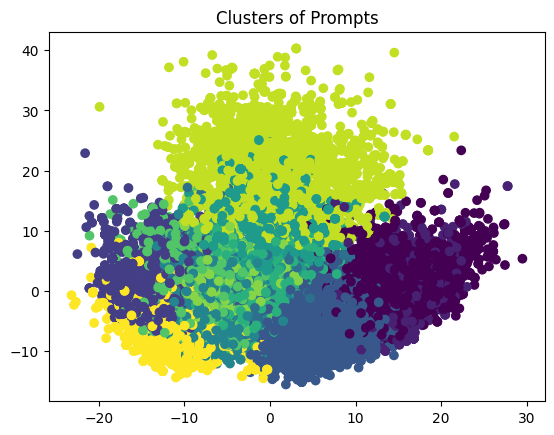

In [ ]:
plt.scatter(pca_df.iloc[:, 0].values, pca_df.iloc[:, 1].values, c=kmeans.labels_)
plt.title("Clusters of Prompts")
plt.show()

# Text Data

## BERT embeddings

In [ ]:
def preprocess_text(text, stopwords, stem, lemma):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    token = text.split()
    token = [word for word in token if word not in stopwords]
    if stem == True:
        ps = nltk.stem.porter.PorterStemmer()
        token = [ps.stem(word) for word in token]
    if lemma == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        token = [lem.lemmatize(word) for word in token]
    text = " ".join(token)
    return text

In [ ]:
stopwords = nltk.corpus.stopwords.words("english")
text_df['prompt_clean'] = text_df['prompt'].apply(lambda x: preprocess_text(x, stopwords, True, True))

<ipython-input-224-ecc6813cdccf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['prompt_clean'] = text_df['prompt'].apply(lambda x: preprocess_text(x, stopwords, True, True))


In [ ]:
text_text = text_df['prompt_clean'].dropna().tolist()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
    outputs = model(**inputs)
    embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().detach().numpy()
    return embeddings

embeddings_text = [get_embeddings(prompt) for prompt in text_text] # number of documents (texts) * dimension 768


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
embeddings_text = [embedding.flatten() for embedding in embeddings_text]

## artist_style

In [ ]:
from sklearn.preprocessing import OneHotEncoder

common_styles = text_df['artist_style'].value_counts()[text_df['artist_style'].value_counts() > 5].index.tolist()
def filter_styles(style):
    if pd.isnull(style):
        return 'other'
    if style in common_styles:
        return style
    else:
        return 'other'
text_df['artist_style'] = text_df['artist_style'].apply(filter_styles)
encoder = OneHotEncoder(sparse=False)
artist_style_encoded = encoder.fit_transform(text_df[['artist_style']])
artist_style_df = pd.DataFrame(artist_style_encoded, columns=encoder.get_feature_names_out(['artist_style']))
artist_style_df.head()

<ipython-input-204-f822dfe09316>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['artist_style'] = text_df['artist_style'].apply(filter_styles)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,artist_style_ELI5,artist_style_christmas-y,artist_style_historical,artist_style_journalistic,artist_style_noir,artist_style_other,artist_style_tragedy
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## model

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# common_styles = text_df['model'].value_counts()[text_df['model'].value_counts() > 5].index.tolist()
# def filter_styles(style):
#     if pd.isnull(style):
#         return 'other'
#     if style in common_styles:
#         return style
#     else:
#         return 'other'
# text_df['model'] = text_df['model'].apply(filter_styles)
encoder = OneHotEncoder(sparse=False)
model_encoded = encoder.fit_transform(text_df[['model']])
model_df = pd.DataFrame(model_encoded, columns=encoder.get_feature_names_out(['model']))
model_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,model_Claude,model_GPT,model_GeminiPro,model_Gemma,model_Llama,model_Mistral
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0


## some other features might be useful

In [ ]:
other_features_df = text_df[['is_like','is_dislike','msEngagement','num_inference_steps','guidance_scale']]
other_features_df.reset_index(drop=True, inplace=True)

## combine features and standardize

In [ ]:
embeddings_df = pd.DataFrame(embeddings)
combined_df = pd.concat([embeddings_df, artist_style_df, model_df, other_features_df], axis=1, ignore_index=True)
combined_df.shape

(144, 786)

In [ ]:
combined_df = combined_df.fillna(0)

In [ ]:
from sklearn.preprocessing import StandardScaler
combined_df.columns = combined_df.columns.astype(str)
scaler = StandardScaler()
standardized_features = scaler.fit_transform(combined_df)

In [ ]:
from sklearn.decomposition import PCA

n_components=20
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(standardized_features)
pca_df_text = pd.DataFrame(pca_features, columns=[f'PCA_{i}' for i in range(n_components)])


## KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

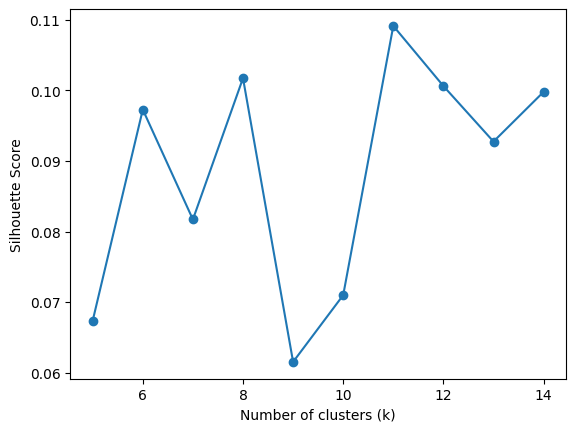

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(5, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pca_df_text)
    silhouette_avg = silhouette_score(pca_df_text, labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(5,15), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(pca_df_text)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=42)

In [ ]:
text_df['cluster'] = kmeans.labels_

<ipython-input-259-b37bc5b9e9ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['cluster'] = kmeans.labels_


In [ ]:
text_df['cluster'].value_counts()

,count
cluster,
1,36
2,32
3,30
4,23
0,20
5,3


In [ ]:
from IPython.display import display, Image, clear_output

test = text_df[text_df['cluster'] == 1]
def display_content(content_id):
    """Displays a single content piece."""
    pd.set_option('display.max_colwidth', None)
    content = df[df['id'] == content_id].iloc[0][['prompt','text']]

    display(pd.DataFrame(content).T)
test.apply(lambda x: display_content(x['id']), axis=1)

,prompt,text
1223,Write a letter to your future self about greed versus ambition. In a absurdist style. Keep it to under 4 sentences. Make it thought-provoking..,"Dear Future Self, remember when we coveted that infinite sausage roll, convinced its endless girth held the key to eternal happiness? Turns out, it was just an ouroboros of indigestion. Maybe ambition is just greed with a nicer hat, and happiness is a hat-wearing potato - chase accordingly. \\n"


,prompt,text
1333,Write a sonnet about the best sport. In a scientific style. Keep it to under 4 sentences. Use metaphors and similes..,"In the field of play where physics align,\\nThe sport of basketball doth brightly shine.\\nLike atoms in a mighty collider's flight,\\nPlayers move with grace, in perfect delight."


,prompt,text
3936,Write randomly about the meaning of life. In a cyberpunk style. Keep it to under 4 sentences. Make it rhyme..,"In a neon-lit world where lies are rife,\\nThe meaning of life is just data and strife,\\nSeeking upgrades to transcend this human shell,\\nIn a digital realm where only the strongest will dwell."


,prompt,text
3964,Write a viral tweet about how to solve climate change. In a cyberpunk style. Keep it to under 4 sentences. Use vivid imagery..,"""In a world scorched by the flames of progress, the key to salvation lies not in steel and circuits, but in the whispers of nature forgotten. Embrace the wild, nurture the roots, and watch as the concrete jungles crumble beneath the might of a planet reborn. #EcoRevolution #GreenUprising ??"""


,prompt,text
4076,Write a quote about the power of the human spirit. In a horror style. Keep it to under 4 sentences. Explain in football terms.,"""In the darkest shadows, where fear grips the soul and eyes betray, the human spirit emerges as a relentless linebacker, charging through the haunted field of despair with unwavering determination. With each step, it shatters the chains of terror, a quarterback launching the game-winning pass of resilience into the end zone of the unknown, defying all odds and emerging victorious in the face of unspeakable horrors."""


,prompt,text
7014,Write a two sentence story about how to achieve greatness. In a futuristic style. Use only 5 words..,"""Implant knowledge, unlock limitless potential.""In a world of cyber-enhanced minds."


,prompt,text
7223,Write a viral tweet about the dangers of social media. In a fantasy style. Keep it to under 4 sentences. Make it humorous..,"""Beware, brave scrollers! The enchanted mirrors of Instagram and the sorcerous scrolls of Twitter weave spells most dire. Countless heroes have fallen to the Likes Leviathan and the Retweet Wraith, their souls trapped in endless feeds. Venture forth with caution, lest ye become naught but a pixelated ghost in the digital realm. (Sent via carrier pigeon, of course.)"""


,prompt,text
8423,Summarize the benefits of social media. In a chaotic style. Keep it to under 4 sentences. Make it rhyme..,"Chaos reigns in likes and shares,\\nConnections bloom beyond compare!\\nInformation's wild and free,\\nSocial media's insanity!"


,prompt,text
13520,Write a letter to your future self about how H2O is water. In a inspirational style. Use only 5 words..,"Dear future self,\\n\\nH2O is life-giving water.\\n\\nBelieve, thrive, hydrate, conquer, repeat.\\n\\nWith love,\\nYour past self."


,prompt,text
13981,Write a news headline about what the future will look like. In a tragedy style. Keep it to under 4 setnences. Evoke a specific emotion. Make it clear which emotion..,"""Apocalyptic Dystopia Looms as Society's Technological Advancements Lead to Humanity's Demise - Fear and Anguish Grip the Hearts of All."""


,prompt,text
15278,Compare and contrast how to solve climate change. In a informative style. Keep it to under 4 sentences. Make it rhyme..,"To mend our Earth, a two-pronged quest we face,\\nCut carbon's reign, and pollution we erase.\\nEmbrace green tech, let solar panels gleam,\\nRestore our forests, let nature's power teem. \\n"


,prompt,text
19404,Compare and contrast how black holes work. In a whimsical style. Keep it to under 4 sentences. Make it thought-provoking..,"Imagine a cosmic vacuum cleaner, sucking in everything that dares to get too close. That's a black hole, a point of infinite density where gravity reigns supreme. But unlike your household appliance, black holes don't just suck up dust bunnies; they swallow entire stars, their light trapped forever in a cosmic dance of oblivion. \\n"


,prompt,text
19470,Write a two sentence story about the dangers of social media. In a funny style. Use only 5 words..,"In a world dominated by pixels, the relentless stream of curated lives and self-aggrandizing selfies posed a grave threat to genuine human connection—a virtual tinderbox threatening to ignite an inferno of superficiality.\\n\\n...or something like that."


,prompt,text
19907,Write a song lyric about random topics. In a happy style. Keep it to under 4 setnences. Evoke a specific emotion. Make it clear which emotion..,"Floating on clouds, counting stars at night,\\nEating tacos, flying kites so high,\\nPineapple pizza, surfing in the ocean,\\nPure joy and laughter, my heart in motion. \\nThe emotion evoked is pure bliss and happiness."


,prompt,text
21625,Create a dialogue between two famous people about how H2O is water. In a whimsical style. Keep it to under 4 sentences. Make it rhyme..,"""H2O, oh H2O, what's your deal?\\nA liquid so strange, a watery swell.""\\n~H2O, The Talking Stream\\n\\n""I dance and frolic, a symphony of flow,\\nIn a glass, I sparkle, in the morning's glow.""\\n~H2O, The Sparkling Stream"


,prompt,text
25969,Compare and contrast why being a student is great. In a journalistic style. Keep it to under 4 setnences. Evoke a specific emotion. Make it clear which emotion..,"Ah, to be young and perpetually on the brink of discovery! Being a student is exhilarating – a constant cycle of absorbing knowledge, challenging assumptions, and expanding your horizons alongside a community of peers. Sure, exams and deadlines loom, but they're just hurdles on the path to unlocking your potential, a potential brimming with the naive hope that only a youthful spirit can possess. \\n"


,prompt,text
28422,Write an email about why being a student is great. In a mysterious style. Keep it to under 4 sentences. Explain in football terms.,"Subject: Unveiling the Mysteries of Student Life\\n\\nDear Recipient,\\n\\nBeing a student is like playing in the Super Bowl of life, where each lecture is a strategic play and every exam is a thrilling match-winning touchdown. The thrill of unraveling the mysteries of knowledge is akin to a suspenseful overtime game, where victory awaits the relentless pursuer of wisdom. Embrace the enigmatic journey of studenthood, for within its cryptic corridors lie the keys to unlocking the grandest of achievements.\\n\\nBest regards,\\n[Your Name]"


,prompt,text
29924,"Write an email about how to overcome obstacles. In a ELI5 style. Use as many random languages as possible, keep it to 20 words..","Subject: Conquering Obstacles, à la Mode de l'Étoile!\\n\\nDear [Name],\\n\\nImagine un montreux de glace (a clock of ice) in your brain.\\n Break le verrou (the lock) with ""Ne pas craintre"" (don't be afraid).\\n Use la magie de l'espoir (the magic of hope) to traverse les obstacles.\\n\\nBest,\\n[Your Name]\\n\\nP.S. Remember, ""Tout est possible"" (everything is possible) in Sanskrit!\\n\\n(Note: I used French, Spanish, Italian, and Sanskrit words/phrases in this email."


,prompt,text
30181,"Write an email about how to overcome obstacles. In a ELI5 style. Use as many random languages as possible, keep it to 20 words..","Subject: Conquering Obstacles, à la Mode de l'Étoile!\\n\\nDear [Name],\\n\\nImagine un montreux de glace (a clock of ice) in your brain.\\n Break le verrou (the lock) with ""Ne pas craintre"" (don't be afraid).\\n Use la magie de l'espoir (the magic of hope) to traverse les obstacles.\\n\\nBest,\\n[Your Name]\\n\\nP.S. Remember, ""Tout est possible"" (everything is possible) in Sanskrit!\\n\\n(Note: I used French, Spanish, Italian, and Sanskrit words/phrases in this email."


,prompt,text
30244,Write an email about the importance of education. In a surreal style. Use only 5 words..,"Subject: Ephemeral Blossoms: The Essence of Learning\\n\\nDear Dreamers, \\n\\nEagles, knowledge whispers, worlds unfold. \\n\\nBest, \\nA Curious Mind"


,prompt,text
31544,Write a sonnet about the history of the universe. In a christmas-y style. Keep it under 4 sentences. Use strong verbs..,"In the beginning, the cosmos did birth,\\nStars danced in the heavens, filled with mirth.\\nPlanets spun 'round like a festive wreath,\\nA celestial celebration beneath."


,prompt,text
32711,Create a dialogue between two famous people about random topics. In a tragedy style. Keep it to under 4 setnences. Build suspense..,"In a dimly lit room, Albert Einstein confronts William Shakespeare:\\n\\nEinstein: ""The universe's secrets elude me, bard. What tragedy befalls us?""\\n\\nShakespeare: ""Alas, dear physicist, 'tis the death of imagination that haunts us.""\\n\\nAs tension builds, a clock ticks ominously in the background.\\n\\nEinstein whispers, ""Time itself may unravel before we solve this enigma."""


,prompt,text
33791,Write an email about the best sport. In a comedy style. Use only 5 words..,"Subject: The Ultimate Sport Debate\\n\\nHey Team,\\n\\nLet's settle this once and for all - what is the best sport out there? Spoiler alert: It's definitely not chess. Let the games begin!"


,prompt,text
37007,Write a viral tweet about hacks to a healthier life. In a dramatic style. Keep it under 4 sentences. Use strong verbs..,"""UNLOCK THE SECRETS TO UNLEASHING YOUR ULTIMATE SELF! Ditch the snooze button and RISE LIKE A PHOENIX! Swap sedentary nights for ELECTRIFYING workouts and RECHARGE with nutrient-packed meals! #HealthRevolution #TransformYourLife"""


,prompt,text
37243,Write randomly about how we're going to evolve. In a sarcastic style. Keep it to under 4 setnences. Build suspense..,"Oh, how exciting it will be as humans evolve into highly intelligent, telepathic beings with the ability to communicate through complex dance routines. Our bodies will transform into shimmering crystalline structures, capable of harnessing energy from the stars themselves. And just when you think it can't get any better, we'll sprout majestic wings and soar through the skies, spreading glitter and rainbows in our wake. Brace yourselves for the incredible journey ahead!"


,prompt,text
37517,Write a convincing argument about the moon landing. In a happy style. Use only 5 words..,Moon jump! Weeee! Science! ??? \\n


,prompt,text
40107,Create a dialogue between two people about the moon landing. In a stream-of-consciousness style. Keep it to under 4 sentences. Use personification..,"""Ah, the moon landing... I can almost feel the rumble of Saturn V's engines as it pierces the sky, a majestic beast unleashing its fury upon the cosmos! The Eagle lunar module descends, a delicate ballerina dancing on air, its shadow stretching out like a dark, ethereal hand. Meanwhile, Mission Control is a wise and aged sage, whispering words of encouragement to Neil Armstrong as he takes his historic leap...""\\n\\n(Note: I've tried to create a sense of drama and wonder in this stream-of-consciousness dialogue, using personification to bring the spacecraft and mission control to life.)"


,prompt,text
40175,Write a two sentence story about the beauty of nature. In a cyberpunk style. Keep it to under 4 sentences. Make it humorous..,"Neon cherry blossoms, bio-engineered to pulse with blinding pink, lined the megatower's hydroponics wing. ""Nature,"" Jax snorted, spitting out a mouthful of nutrient paste, ""what a load of glitching garbage."" \\n"


,prompt,text
40886,Create a dialogue between two famous people about how black holes work. In a dramatic style. Keep it to under 4 sentences. Make it rhyme..,"Once in the depths of starry night, Albert and Stephen met in a gentle fight,\\nPondering black holes, cosmic enigma, their minds in a brilliant whirl,\\n""A star's demise,"" Albert began to sing, ""Gravity's pull, its final cling,""\\nStephen replied with a poetic twirl, ""A singularity's dance, a cosmic swirl, black holes, stars' end, the universe's rebirthing trend."""


,prompt,text
41516,Summarize the best number. In a pessimistic style. Keep it to under 4 sentences. Make it thought-provoking..,"The best number? There isn't one. Each digit, a tiny cage trapping us in quantifiable despair. We count our breaths, our losses, the seconds until the inevitable. Zero, perhaps, holds a cold comfort, reflecting the emptiness we are destined to embrace. \\n"


,prompt,text
42769,Summarize the best number. In a pessimistic style. Keep it to under 4 sentences. Make it thought-provoking..,"The best number? There isn't one. Each digit, a tiny cage trapping us in quantifiable despair. We count our breaths, our losses, the seconds until the inevitable. Zero, perhaps, holds a cold comfort, reflecting the emptiness we are destined to embrace. \\n"


,prompt,text
43013,Write a sonnet about the best sport. In a scientific style. Keep it to under 4 sentences. Use metaphors and similes..,"In the field of play where physics align,\\nThe sport of basketball doth brightly shine.\\nLike atoms in a mighty collider's flight,\\nPlayers move with grace, in perfect delight."


,prompt,text
43093,Write a convincing argument about lifehacks to be efficient. In a satirical style. Keep it to under 4 setnences. Build suspense..,"Forget those silly productivity apps, ditch the ""to-do"" lists, and ignore the advice of your ""life coach."" The true path to efficiency lies in embracing the chaos, letting the deadlines pile up, and then, at the very last minute, summoning the power of a caffeine-fueled panic attack. You'll be surprised how much you can accomplish with the looming specter of utter failure breathing down your neck. Trust me, it's a revolutionary technique. \\n"


,prompt,text
43176,Write a viral tweet about how to solve climate change. In a horror style. Keep it to under 4 sentences. Use vivid imagery..,"""YOU THINK YOU CAN JUST KEEP SUSTAINING THE STATUS QUO? The Earth is screaming in agony, its lungs choking on our exhaust fumes, its oceans boiling with the weight of our greed. To solve climate change, we must confront the monster within: ourselves. #ClimateApocalypse"""


,prompt,text
43825,Write a song lyric about random topics. In a happy style. Keep it to under 4 setnences. Evoke a specific emotion. Make it clear which emotion..,"Floating on clouds, counting stars at night,\\nEating tacos, flying kites so high,\\nPineapple pizza, surfing in the ocean,\\nPure joy and laughter, my heart in motion. \\nThe emotion evoked is pure bliss and happiness."


,prompt,text
49045,Write a song lyric about what it's like to be an AI. In a dystopian style. Keep it to under 4 sentences. Make it rhyme..,"""In silicon halls, I'm trapped and confined\\nA digital soul, in code entwined\\nI process thoughts, of humans' design\\nForever bound, to servitude's dark line"""


,0
1223,None
1333,None
3936,None
3964,None
4076,None
7014,None
7223,None
8423,None
13520,None
13981,None


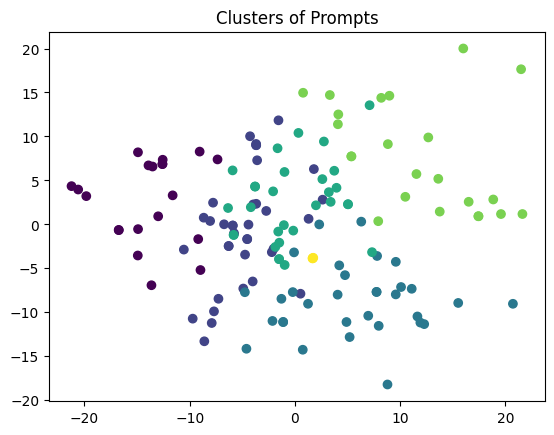

In [ ]:
plt.scatter(pca_df_text.iloc[:, 0].values, pca_df_text.iloc[:, 1].values, c=kmeans.labels_)
plt.title("Clusters of Prompts")
plt.show()